In [1]:
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue
# https://matplotlib.org/users/dflt_style_changes.html

# Extracting observed Conc.

In [3]:
obs_d13c = pd.read_table(path + 'observations/d13c_bulk_cal.tss')
obs_conc = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs_d13c.head()

,Jdays,DayMoYr,IDcal,d13C,d13C.SD
0,188,2016-04-05,B-188,-31.225186,0.640023
1,197,2016-04-14,B-197,-31.200375,0.303478
2,201,2016-04-18,B-201,-31.496359,0.390947
3,209,2016-04-26,B-209,-31.239331,0.542286
4,216,2016-05-03,B-216,-30.682124,0.434045


# Selecting indexes

In [4]:
gen_1x = "Gen10"
df = get_data(gen=gen_1x)
df["Gen"] = gen_1x

In [5]:
# Index names
df['Name'] = df['Gen'] + "/" + df.index
df = df.set_index('Name')
# 'LHS_s2fix7/10/' in list(df.index)

In [6]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-blk'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-blk'])/2.0
df['epsilon_iso'] *= -1
dfs_all = df[['Model', "Gen",
          'dt_50_ref',
          'dt_50_ab',
          'k_d',
          'k_oc',
          'epsilon_iso',
          'KGE-CONC-blk','KGE-d13C-blk',
          'KGE-CONC-tra','KGE-d13C-tra',
          'KGE-CONC-det','KGE-d13C-det',
          'KGE-CONC_out', 'KGE-d13C_out',
          'KGE-SM', 'KGE-d13C',
          'KGE-Q_out'
          ]]

In [7]:
# Filter
# cst = 0.8
# dfs['Constraint'] = dfs.apply(BlkIso, args=(cst,), axis=1)

dfs = dfs_all.loc[(dfs_all['Model'] == 'var')]
dfs_fix = dfs_all.loc[(dfs_all['Model'] == 'fix')]


# Global
# ff = dfs.loc[(dfs['KGE-SM'] > 0.5)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-SM'] > 0.25) & (dfs['KGE-d13C'] >  cst)]

# Soil
ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.60) & (dfs['KGE-Q_out'] >  0.50)] # Try 25 with more data points
ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.0) & (dfs['KGE-d13C-blk'] >  0.80) & (dfs['KGE-Q_out'] >  0.50)]


# Outlet
# ff = dfs.loc[(dfs['KGE-CONC_out'] > 0.20)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC_out'] > 0.20) & (dfs['KGE-d13C_out'] >  0.2)]

print(len(dfs), len(ff), len(ff_c))
# ff.tail()
print(len(ff_c.loc[(ff_c['Gen']=="Gen10")]))

(1635, 184, 111)
111


In [8]:
# New sampling
# dfs_fix

## All models

In [9]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.769832923058568, 0.5284275029940944)
Maximum Conc.
(0.8027419410432288, 0.483226275596356, 0.5657178152771112)
Maximum d13C
(0.957449515054865, 0.6328847080874456, 0.7543872543883461)


## Convert to arrays

https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

In [10]:
all_gen1x = dfs_all.loc[(dfs_all['Gen'] == 'Gen10')]
nc_all_blk = all_gen1x.loc[(all_gen1x['KGE-CONC-blk'] > 0.6) & (all_gen1x['KGE-d13C-blk'] >  0.0) & (all_gen1x['KGE-Q_out'] >  0.50) ]

nc_mean_all = nc_all_blk["dt_50_ref"].mean()
nc_sd_all = nc_all_blk["dt_50_ref"].std()
print(nc_mean_all,nc_sd_all) 

(21.053268503310637, 9.377714163164637)


In [11]:
ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.50) & (dfs['KGE-d13C-blk'] >  0.70) & (dfs['KGE-Q_out'] >  0.545)]

In [12]:
# Soil Detailed
# ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.60) & (dfs['KGE-Q_out'] >  0.50)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.60) & (dfs['KGE-d13C-blk'] >  0.50)]
gen1x = dfs.loc[(dfs['Gen'] == 'Gen10')]
# gen2x = dfs.loc[(dfs['Gen'] == 'Gen11')]

# blk = gen1x.loc[(gen1x['KGE-CONC-blk'] > 0.0) & (gen1x['KGE-d13C-blk'] >  0.85) & (gen1x['KGE-Q_out'] >  0.50) ]
# tra = gen1x.loc[(gen1x['KGE-CONC-blk'] > 0.0) & (gen1x['KGE-d13C-tra'] >  0.85) & (gen1x['KGE-Q_out'] >  0.50) ]
# det = gen1x.loc[(gen1x['KGE-CONC-blk'] > 0.0) & (gen1x['KGE-d13C-det'] >  0.82) & (gen1x['KGE-Q_out'] >  0.50) ]

# Good:
# blk_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-blk'] >  -3.0) & (gen1x['KGE-Q_out'] >  0.50)]
# tra_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-tra'] >  -3.0) & (gen1x['KGE-Q_out'] >  0.50)]
# det_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-det'] >  -3.0) & (gen1x['KGE-Q_out'] >  0.50)]

# blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-blk'] >  0.82) & (gen1x['KGE-Q_out'] >  0.50)]
# tra_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-tra'] >  0.82) & (gen1x['KGE-Q_out'] >  0.50)]
# det_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-det'] >  0.82) & (gen1x['KGE-Q_out'] >  0.50)]

# Good:
blk_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-blk'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]
tra_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-tra'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]
det_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-det'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]

blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-blk'] >  0.85) & (gen1x['KGE-Q_out'] >  0.545)]
tra_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-tra'] >  0.85) & (gen1x['KGE-Q_out'] >  0.545)]
det_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-det'] >  0.82) & (gen1x['KGE-Q_out'] >  0.545)]


# Test 2 (including K_d)
# blk_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-blk'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]
# tra_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-tra'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]
# det_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-det'] >  0.0) & (gen1x['KGE-Q_out'] >  0.545)]

# blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-blk'] >  0.82) & (gen1x['KGE-Q_out'] >  0.545)]
# tra_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-tra'] >  0.82) & (gen1x['KGE-Q_out'] >  0.545)]
# det_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .6) & (gen1x['KGE-d13C-det'] >  0.82) & (gen1x['KGE-Q_out'] >  0.545)]


In [13]:
nc_mean_blk = blk_c["dt_50_ref"].mean()
nc_sd_blk = blk_c["dt_50_ref"].std()
print(nc_mean_blk,nc_sd_blk) 

nc_mean_tra = tra_c["dt_50_ref"].mean()
nc_sd_tra = tra_c["dt_50_ref"].std()
print(nc_mean_tra, nc_sd_tra) 

nc_mean_det = det_c["dt_50_ref"].mean()
nc_sd_det = det_c["dt_50_ref"].std()
print(nc_mean_det,nc_sd_det) 

(16.568234508042632, 8.790863733477835)
(17.8720096816432, 9.404959073031922)
(19.00653927757153, 9.984115397305532)


In [14]:
wc_mean_blk = blk_b["dt_50_ref"].mean()
wc_sd_blk = blk_b["dt_50_ref"].std()
print(wc_mean_blk, wc_sd_blk) 

wc_mean_tra = tra_b["dt_50_ref"].mean()
wc_sd_tra = tra_b["dt_50_ref"].std()
print(wc_mean_tra, wc_sd_tra) 

wc_mean_det = det_b["dt_50_ref"].mean()
wc_sd_det = det_b["dt_50_ref"].std()
print(wc_mean_det, wc_sd_det) 

(17.047260509062127, 3.9496981486422693)
(20.701598767715762, 3.5334578729743167)
(16.010408221047964, 7.1932346903693345)


In [15]:
e_blk = blk_b["epsilon_iso"].mean()
e_tra = tra_b["epsilon_iso"].mean()
e_det = det_b["epsilon_iso"].mean()

print(e_blk, e_tra, e_det)

e_sd_blk = blk_b["epsilon_iso"].std()
e_sd_tra = tra_b["epsilon_iso"].std()
e_sd_det = det_b["epsilon_iso"].std()

print(e_sd_blk, e_sd_tra, e_sd_det)

(-2.593883483111037, -2.3542871839114667, -1.4340723111289302)
(0.4364025170067323, 0.46452037021432674, 0.6641457898089228)


In [16]:
AKIE = 1./(1+(15*e_blk/1000.))
AKIE_sd = 1./(1+(15*(e_blk-e_sd_blk)/1000.)) - AKIE

AKIE_blk = round(AKIE, 2)
AKIE_blk_sd = round(AKIE_sd, 2)
print(AKIE_blk, AKIE_blk_sd)

AKIE = 1./(1+(15*e_det/1000.))
AKIE_sd = 1./(1+(15*(e_det-e_sd_det)/1000.)) - AKIE

AKIE_det = round(AKIE, 2)
AKIE_det_sd = round(AKIE_sd, 2)
print(AKIE_det, AKIE_det_sd)

(1.04, 0.01)
(1.02, 0.01)


In [17]:
# Non-constrained sets
fix = dfs_fix.loc[(dfs_fix['Gen'] == 'Gen10')]

blk_x = fix.loc[(fix['KGE-CONC-blk'] > .545) & (fix['KGE-d13C-blk'] >  -3.0) & (fix['KGE-Q_out'] >  0.50)]
tra_x = fix.loc[(fix['KGE-CONC-tra'] > .545) & (fix['KGE-d13C-tra'] >  -3.0) & (fix['KGE-Q_out'] >  0.50)]
det_x = fix.loc[(fix['KGE-CONC-det'] > .545) & (fix['KGE-d13C-det'] >  -3.0) & (fix['KGE-Q_out'] >  0.50)]

# blk_x = fix.loc[(fix['KGE-CONC-blk'] > .5) & (fix['KGE-d13C-blk'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# tra_x = fix.loc[(fix['KGE-CONC-blk'] > .5) & (fix['KGE-d13C-tra'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# det_x = fix.loc[(fix['KGE-CONC-blk'] > .5) & (fix['KGE-d13C-det'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]

# Test 2

# blk_x = fix.loc[(fix['KGE-CONC-blk'] > .65) & (fix['KGE-d13C-blk'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# tra_x = fix.loc[(fix['KGE-CONC-blk'] > .65) & (fix['KGE-d13C-tra'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# det_x = fix.loc[(fix['KGE-CONC-blk'] > .65) & (fix['KGE-d13C-det'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]

nc_fix_blk = blk_x["dt_50_ref"].mean()
nc_fix_sd_blk = blk_x["dt_50_ref"].std()
nc_fix_blk

nc_fix_tra = tra_x["dt_50_ref"].mean()
nc_fix_sd_tra = tra_x["dt_50_ref"].std()

nc_fix_det = det_x["dt_50_ref"].mean()
nc_fix_sd_det = det_x["dt_50_ref"].std()

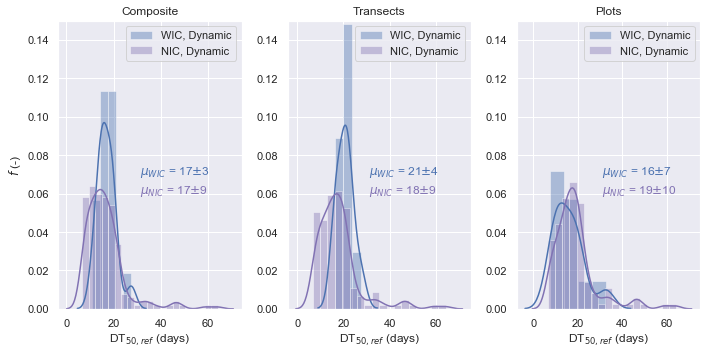

In [18]:
sns.set(rc={'figure.figsize':(11.5, 5.3)}) # Width, height, inches
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False)

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

# sns.distplot( blk["dt_50_ref"] , color="C4", label="Delta", ax=ax1)
sns.distplot( blk_b["dt_50_ref"] , color="C0", label="WIC, Dynamic", ax=ax1)
sns.distplot( blk_c["dt_50_ref"] , color="C4", label="NIC, Dynamic", ax=ax1)
# sns.distplot( blk_x["dt_50_ref"] , color="C3", label="NIC,fix", ax=ax1)

sns.distplot( tra_b["dt_50_ref"] , color="C0", label="WIC, Dynamic", ax=ax2)
sns.distplot( tra_c["dt_50_ref"] , color="C4", label="NIC, Dynamic", ax=ax2)
# sns.distplot( tra_x["dt_50_ref"] , color="C3", label="NIC,fix", ax=ax2)

sns.distplot( det_b["dt_50_ref"] , color="C0", label="WIC, Dynamic", ax=ax3)
sns.distplot( det_c["dt_50_ref"] , color="C4", label="NIC, Dynamic", ax=ax3)
# sns.distplot( det_x["dt_50_ref"] , color="C3", label="NIC,fix", ax=ax3)

# # sns.distplot( blk2x["dt_50_ref"] , color="C4", label="blk2x", ax=ax)
# # sns.distplot( tra2x["dt_50_ref"] , color="C3", label="tra2x", ax=ax)
# # sns.distplot( det2x["dt_50_ref"] , color="C0", label="det2x", ax=ax)

ax1.set_xlabel("DT$_{50,ref}$ (days)")
ax2.set_xlabel("DT$_{50,ref}$ (days)")
ax3.set_xlabel("DT$_{50,ref}$ (days)")
ax1.set_ylabel("$f$ (-)")

ax1.set_title("Composite")
ax2.set_title("Transects")
ax3.set_title("Plots")

ax1.legend()
ax2.legend()
ax3.legend()

# ax1.annotate('$\overline{DegT_{50}}$='+str(round(nc_mean_blk, 1)), xy=(30, 0.06), # 1.2 
#                  xycoords='data')
ax1.set_ylim(0.0, 0.15)
ax1.annotate('$\mu_{WIC}$ = '+ str(int(round(wc_mean_blk,0))) + 
             '$\pm$' + str(int(wc_sd_blk)), xy=(31, 0.07), # 1.2 
                 xycoords='data', color="C0")

ax1.annotate('$\mu_{NIC}$ = '+str(int(round(nc_mean_blk, 0))) + 
             '$\pm$' + str(int(round(nc_sd_blk,0))), xy=(31, 0.06), # 1.2 
                 xycoords='data', color="C4")


# ax1.annotate('$\mu_{NIC,fix}$ = '+str(int(round(nc_fix_blk,0))) + 
#              '$\pm$' + str(int(round(nc_fix_sd_blk, 0))) , xy=(31, 0.05), # 1.2 
#                  xycoords='data', color="C3")




# B
ax2.annotate('$\mu_{WIC}$ = '+str(int(round(wc_mean_tra, 0))) + 
             '$\pm$' + str(int(round(wc_sd_tra,0))), xy=(31, 0.07), # 1.2 
                 xycoords='data', color="C0")

ax2.annotate('$\mu_{NIC}$ = '+str(int(round(nc_mean_tra, 0))) + 
             '$\pm$' + str(int(round(nc_sd_tra,0))), xy=(31, 0.06), # 1.2 
                 xycoords='data', color="C4")

# ax2.annotate('$\mu_{NIC,fix}$ = '+str(int(round(nc_fix_tra,0))) + 
#              '$\pm$' + str(int(round(nc_fix_sd_tra, 0))) , xy=(31, 0.05), # 1.2 
#                  xycoords='data', color="C3")

ax2.set_ylim(0.0, 0.15)

# C
ax3.annotate('$\mu_{WIC}$ = '+str(int(round(wc_mean_det, 0))) + 
             '$\pm$' + str(int(round(wc_sd_det,0))), xy=(31, 0.07), # 1.2 
                 xycoords='data', color="C0")

ax3.annotate('$\mu_{NIC}$ = '+str(int(round(nc_mean_det, 0))) + 
             '$\pm$' + str(int(round(nc_sd_det,0))), xy=(31, 0.06), # 1.2 
                 xycoords='data', color="C4")
# ax3.annotate('$\mu_{NIC,fix}$ = '+str(int(round(nc_fix_det,0))) + 
#              '$\pm$' + str(int(round(nc_fix_sd_det, 0))) , xy=(31, 0.05), # 1.2 
#                  xycoords='data', color="C3")
ax3.set_ylim(0.0, 0.15)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.25, hspace=None)

# fig.savefig("Fig3a_DegT50.pdf")

In [19]:
24/18.

1.3333333333333333

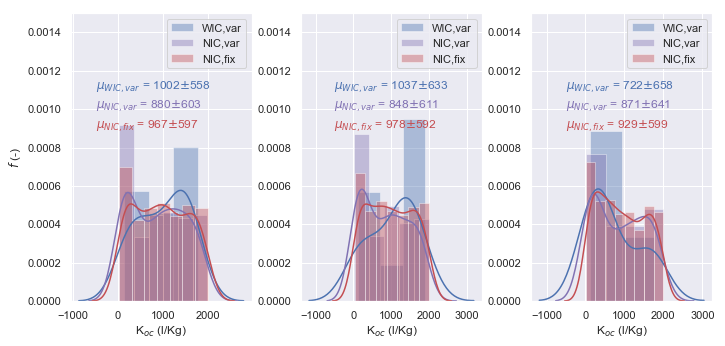

In [20]:
sns.set(rc={'figure.figsize':(11.5, 5.3)}) # Width, height, inches
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False)

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

# sns.distplot( blk["dt_50_ref"] , color="C4", label="Delta", ax=ax1)
sns.distplot( blk_b["k_oc"] , color="C0", label="WIC,var", ax=ax1)
sns.distplot( blk_c["k_oc"] , color="C4", label="NIC,var", ax=ax1)
sns.distplot( blk_x["k_oc"] , color="C3", label="NIC,fix", ax=ax1)

ax1.set_ylim(0.0, 0.0015)
ax1.annotate('$\mu_{WIC,var}$ = '+ str(int(round(blk_b["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(blk_b["k_oc"].std(),0))), xy=(-500, 0.0011), # 1.2 
                 xycoords='data', color="C0")
ax1.annotate('$\mu_{NIC,var}$ = '+ str(int(round(blk_c["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(blk_c["k_oc"].std(),0))), xy=(-500, 0.0010), # 1.2 
                 xycoords='data', color="C4")

ax1.annotate('$\mu_{NIC,fix}$ = '+ str(int(round(blk_x["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(blk_x["k_oc"].std(),0))), xy=(-500, 0.0009), # 1.2 
                 xycoords='data', color="C3")

sns.distplot( tra_b["k_oc"] , color="C0", label="WIC,var", ax=ax2)
sns.distplot( tra_c["k_oc"] , color="C4", label="NIC,var", ax=ax2)
sns.distplot( tra_x["k_oc"] , color="C3", label="NIC,fix", ax=ax2)

ax2.set_ylim(0.0, 0.0015)
ax2.annotate('$\mu_{WIC,var}$ = '+ str(int(round(tra_b["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(tra_b["k_oc"].std(),0))), xy=(-500, 0.0011), # 1.2 
                 xycoords='data', color="C0")
ax2.annotate('$\mu_{NIC,var}$ = '+ str(int(round(tra_c["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(tra_c["k_oc"].std(),0))), xy=(-500, 0.0010), # 1.2 
                 xycoords='data', color="C4")

ax2.annotate('$\mu_{NIC,fix}$ = '+ str(int(round(tra_x["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(tra_x["k_oc"].std(),0))), xy=(-500, 0.0009), # 1.2 
                 xycoords='data', color="C3")

sns.distplot( det_b["k_oc"] , color="C0", label="WIC,var", ax=ax3)
sns.distplot( det_c["k_oc"] , color="C4", label="NIC,var", ax=ax3)
sns.distplot( det_x["k_oc"] , color="C3", label="NIC,fix", ax=ax3)

ax3.set_ylim(0.0, 0.0015)
ax3.annotate('$\mu_{WIC,var}$ = '+ str(int(round(det_b["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(det_b["k_oc"].std(),0))), xy=(-500, 0.0011), # 1.2 
                 xycoords='data', color="C0")
ax3.annotate('$\mu_{NIC,var}$ = '+ str(int(round(det_c["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(det_c["k_oc"].std(),0))), xy=(-500, 0.0010), # 1.2 
                 xycoords='data', color="C4")

ax3.annotate('$\mu_{NIC,fix}$ = '+ str(int(round(det_x["k_oc"].mean(), 0))) + 
             '$\pm$' + str(int(round(det_x["k_oc"].std(),0))), xy=(-500, 0.0009), # 1.2 
                 xycoords='data', color="C3")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlabel("K$_{oc}$ (l/Kg)")
ax2.set_xlabel("K$_{oc}$ (l/Kg)")
ax3.set_xlabel("K$_{oc}$ (l/Kg)")
ax1.set_ylabel("$f$ (-)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.27, hspace=None)

# fig.savefig("Fig3b_Koc.pdf")

In [21]:
print(blk_b["k_d"].mean(), blk_c["k_d"].mean(), blk_x["k_d"].mean())
print(tra_b["k_d"].mean(), tra_c["k_d"].mean(), tra_x["k_d"].mean())
print(det_b["k_d"].mean(), det_c["k_d"].mean(), det_x["k_d"].mean())

(27.751403182209554, 26.300209196640974, 28.210137502707063)
(26.157521794462937, 24.84745617604673, 28.757615527814437)
(20.807813747416, 25.249150151543848, 27.013491943995582)


In [22]:
print(blk_b["k_d"].std(), blk_c["k_d"].std(), blk_x["k_d"].std())
print(tra_b["k_d"].std(), tra_c["k_d"].std(), tra_x["k_d"].std())
print(det_b["k_d"].std(), det_c["k_d"].std(), det_x["k_d"].std())

(24.57423490933382, 22.35947977826747, 22.213082904490566)
(25.335417535075187, 21.915975986211265, 22.223074950109005)
(22.826606592681916, 23.13372660348601, 21.79080939085547)


In [23]:
# fix = dfs_fix.loc[(dfs_fix['Gen'] == 'Gen10')]

# blk_c = fix.loc[(fix['KGE-CONC-blk'] > .6) & (fix['KGE-d13C-blk'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# tra_c = fix.loc[(fix['KGE-CONC-blk'] > .6) & (fix['KGE-d13C-tra'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]
# det_c = fix.loc[(fix['KGE-CONC-blk'] > .6) & (fix['KGE-d13C-det'] >  0.0) & (fix['KGE-Q_out'] >  0.50)]

# blk_b = fix.loc[(fix['KGE-CONC-blk'] > .0) & (fix['KGE-d13C-blk'] >  0.82) & (fix['KGE-Q_out'] >  0.50)]
# tra_b = fix.loc[(fix['KGE-CONC-blk'] > .0) & (fix['KGE-d13C-tra'] >  0.82) & (fix['KGE-Q_out'] >  0.50)]
# det_b = fix.loc[(fix['KGE-CONC-blk'] > .0) & (fix['KGE-d13C-det'] >  0.82) & (fix['KGE-Q_out'] >  0.50)]

# len(blk_c)

In [24]:
# nc_mean_blk = blk_c["dt_50_ref"].mean()
# nc_sd_blk = blk_c["dt_50_ref"].std()
# print(nc_mean_blk,nc_sd_blk) 

# nc_mean_tra = tra_c["dt_50_ref"].mean()
# nc_sd_tra = tra_c["dt_50_ref"].std()
# print(nc_mean_tra, nc_sd_tra) 

# nc_mean_det = det_c["dt_50_ref"].mean()
# nc_sd_det = det_c["dt_50_ref"].std()
# print(nc_mean_det,nc_sd_det) 

# wc_mean_blk = blk_b["dt_50_ref"].mean()
# wc_sd_blk = blk_b["dt_50_ref"].std()
# print(wc_mean_blk, wc_sd_blk) 

# wc_mean_tra = tra_b["dt_50_ref"].mean()
# wc_sd_tra = tra_b["dt_50_ref"].std()
# print(wc_mean_tra, wc_sd_tra) 

# wc_mean_det = det_b["dt_50_ref"].mean()
# wc_sd_det = det_b["dt_50_ref"].std()
# print(wc_mean_det, wc_sd_det) 

In [25]:
# sns.set(rc={'figure.figsize':(9.5, 5.3)}) # Width, height, inches
# fig, ax = plt.subplots(1, 3, sharex=False, sharey=False)

# ax1 = ax[0]
# ax2 = ax[1]
# ax3 = ax[2]

# # sns.distplot( blk["dt_50_ref"] , color="C4", label="Delta", ax=ax1)
# sns.distplot( blk_c["dt_50_ref"] , color="C4", label="NC", ax=ax1)
# sns.distplot( blk_b["dt_50_ref"] , color="C0", label="WC", ax=ax1)


# sns.distplot( tra_c["dt_50_ref"] , color="C4", label="NC", ax=ax2)
# sns.distplot( tra_b["dt_50_ref"] , color="C0", label="WC", ax=ax2)


# sns.distplot( det_c["dt_50_ref"] , color="C4", label="NC", ax=ax3)
# sns.distplot( det_b["dt_50_ref"] , color="C0", label="WC", ax=ax3)

# # # sns.distplot( blk2x["dt_50_ref"] , color="C4", label="blk2x", ax=ax)
# # # sns.distplot( tra2x["dt_50_ref"] , color="C3", label="tra2x", ax=ax)
# # # sns.distplot( det2x["dt_50_ref"] , color="C0", label="det2x", ax=ax)

# ax1.annotate('$\mu_{NC}$ = '+str(round(nc_mean_blk, 1)) + '$\pm$' + str(round(nc_sd_blk,1)), xy=(25, 0.07), # 1.2 
#                  xycoords='data')
# ax1.annotate('$\mu_{WC}$ = '+str(round(wc_mean_blk, 1)) + '$\pm$' + str(round(wc_sd_blk,1)), xy=(25, 0.065), # 1.2 
#                  xycoords='data')

# ax2.annotate('$\mu_{NC}$ = '+str(round(nc_mean_tra, 1)) + '$\pm$' + str(round(nc_sd_tra,1)), xy=(22, 0.05), # 1.2 
#                  xycoords='data')
# ax2.annotate('$\mu_{WC}$ = '+str(round(wc_mean_tra, 1)) + '$\pm$' + str(round(wc_sd_tra,1)), xy=(22, 0.04), # 1.2 
#                  xycoords='data')

# ax3.annotate('$\mu_{NC}$ = '+str(round(nc_mean_det, 1)) + '$\pm$' + str(round(nc_sd_det,1)), xy=(22, 0.1), # 1.2 
#                  xycoords='data')
# ax3.annotate('$\mu_{WC}$ = '+str(round(wc_mean_det, 1)) + '$\pm$' + str(round(wc_sd_det,1)), xy=(22, 0.09), # 1.2 
#                  xycoords='data')

# ax1.set_xlabel("DegT$_{50,ref}$ (days)")
# ax2.set_xlabel("DegT$_{50,ref}$ (days)")
# ax3.set_xlabel("DegT$_{50,ref}$ (days)")
# ax1.set_ylabel("$f$ (-)")

# ax1.set_title("Bulk")
# ax2.set_title("Transects")
# ax3.set_title("Plots")

# ax1.legend()
# ax2.legend()
# ax3.legend()